In [16]:
import tensorflow.compat.v1 as tf

#import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm_notebook

from tensorflow.keras.models import Sequential, Model, clone_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

from utils import get_epsilons, plot_reward

print(tf.__version__)
tf.disable_v2_behavior()

2.0.0-beta1


## Create environment

In [5]:
env = gym.make('CartPole-v0')

In [6]:
env.action_space.n

2

In [7]:
env.observation_space.shape[0]

4

## Define policy network

In [8]:
def mlp(observation_space, action_space, shape=[64,64], lr=0.001):
    
    model = Sequential()
    
    model.add(Dense(shape[0], input_shape=observation_space, activation="tanh"))
    for dim in shape[1:]:
        model.add(Dense(dim, activation="tanh"))
    model.add(Dense(action_space, activation="softmax"))
    
    return model

In [9]:
def ppo_loss_function(r, advantage, eps):
    def loss(y_true, y_pred):
        
        ppo_loss =  - tf.reduce_mean(tf.math.minimum(tf.multiply(r, advantage),
                                                    tf.multiply(tf.clip_by_value(r,
                                                                                 tf.subtract(1.,eps),
                                                                                 tf.add(1.,eps)),
                                                                advantage)))
        return ppo_loss
    return loss

In [10]:
def get_ppo_model(policy_model, observation_space, action_space):
    
    # placeholders:
    obs = Input(shape=(observation_space,))
    action = Input(shape=(action_space,))
    old_prob = Input(shape=(1,))
    advantage = Input(shape=(1,))
    eps = Input(shape=(1,))

    out_action = policy_model(obs)
    
    # ppo loss
    prob = tf.reduce_sum(tf.multiply(out_action, action), axis=1)
    r = tf.divide(prob, old_prob)
    
    # ppo model
    ppo_model = Model(inputs=[obs, action, old_prob, advantage, eps], outputs=[out_action])

    # compile model
    optimizer = Adam(lr=0.001)
    ppo_model.compile(optimizer=optimizer, loss=ppo_loss_function(r, advantage, eps))
    
    return ppo_model

In [11]:
def get_action(action_probs, epsilon, env, stochastic=True):
    """
    Get action from actions space. With probability 1-epsilon,
    a random action is sampled, otherwise the action_probs are
    used to get an action. If stochastic, the actions are sampled
    according to the probablities of each action, otherwise the
    action with the highest probability is returned.
    """
    
    if np.random.rand()>epsilon:
        if stochastic:
            action = np.random.choice(list(range(len(action_probs))), p=action_probs)
        else:
            action = np.argmax(action_probs)
    else:
        action = env.action_space.sample()
    return action

def calc_discounted_rewards(r,gamma=0.9):
    """
    Calculate the discounted future rewards with 
    a gamma factor.
    """
    discounted_rewards = []
    
    for i in range(len(r)):
        tmp_rewards = []
        for j in range(len(r)-i):
            tmp_rewards.append(r[i+j]*(gamma**j))
        discounted_rewards.append(np.sum(tmp_rewards))
        
    return np.array(discounted_rewards)
    

In [12]:
def PPO(env, model, n_steps=10*4, epsilon_range=[0.99, 0.1], render=False, eps=0.2, max_steps=200):
    """
    Proximal Policy Optimisation implementation in TensorFlow 2.
    
    args:
        env: OpenAI gym environment
        n_steps=10*4: number of training steps
        epsilon_range=[0.99, 0.1]: epsilon decay range
    """
    
    
    obs_shape = env.observation_space
    action_space = env.action_space.n
    print('obs shape:',obs_shape,'| action space:', action_space)
    
    
    epsilons = get_epsilons(epsilon_range, n_steps)
    
    dummy_scalar = np.zeros((1,1))
    dummy_action = np.zeros((1, action_space))
    dummy_inputs = [dummy_action] + 3*[dummy_scalar]
    
    total_rewards = []
    total_discounted_rewards = []
    observations = []
    rewards = []
    actions = []
    old_prob = []
    losses = []
    gradients = []
    old_model = clone_model(model)

    baseline=0
    current_steps = 0
    game_done = True
    pbar = tqdm_notebook(range(n_steps))
    
    for i in pbar:
        if render:
            env.render()

        if game_done:
            old_model.set_weights(model.get_weights())

            if len(rewards)>0:
                discounted_rewards = calc_discounted_rewards(rewards, gamma=0.9)
                advantage = (discounted_rewards-baseline)
                
                samples = len(observations)
                model.fit(x=[np.array(observations),
                             np.array(actions),
                             np.array(old_prob),
                             np.array(advantage),
                             np.tile(eps, samples)],
                          y=np.array(old_prob), verbose=0)
                
                baseline = np.mean(discounted_rewards)
                total_discounted_rewards += list(discounted_rewards)
                total_rewards.append(sum(rewards))
                pbar.set_description('reward: ' +str(total_rewards[-1]))
            
            obs = env.reset()
            observations = []
            rewards = []
            actions = []
            old_prob = []
            current_steps=0
        
        current_steps += 1
        observations.append(obs)
        action_probs = model.predict([np.expand_dims(obs, axis=0)] + dummy_inputs)
        
        action = get_action(np.squeeze(action_probs), epsilons[i], env, stochastic=False)
        old_prob.append(old_model.predict([np.expand_dims(obs, axis=0)] + dummy_inputs)[:, action])
        
        obs, reward, game_done,_ = env.step(action)
        rewards.append(reward)
        action_vec = np.zeros(action_space)
        action_vec[action]=1
        actions.append(action_vec)
        
        if current_steps>=max_steps:
            game_done=True
        
    #env.close()

    return model, total_rewards

In [13]:
policy_model = mlp([env.observation_space.shape[0]], env.action_space.n)
ppo_model = get_ppo_model(policy_model, env.observation_space.shape[0], env.action_space.n)

In [14]:
model, total_rewards = PPO(env, ppo_model, n_steps=100000, render=False, epsilon_range=[1,0.1], eps=0.2)

W0824 21:51:53.352210 4704441792 deprecation.py:506] From /Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0824 21:51:53.353631 4704441792 deprecation.py:506] From /Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


obs shape: Box(4,) | action space: 2


W0824 21:51:53.735882 4704441792 deprecation.py:323] From /Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/pandas/core/window.py:1833: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


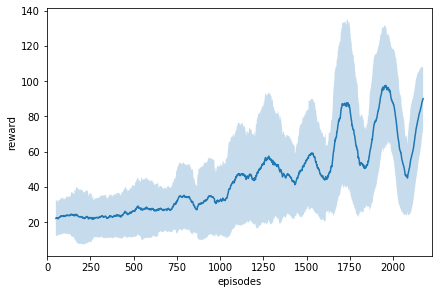

In [17]:
plot_reward(total_rewards, window=100)